<h3> Face Attribute Recognition

In [ ]:
from google.colab import files

# Upload the kaggle.json file
uploaded = files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d jessicali9530/celeba-dataset


!unzip -o -qq celeba-dataset.zip -d "/content/celeba"


Saving kaggle.json to kaggle.json
 99% 1.32G/1.33G [00:14<00:00, 52.2MB/s]
100% 1.33G/1.33G [00:14<00:00, 99.4MB/s]


In [ ]:
import os

# Directory containing the extracted images
celeba_folder = '/content/celeba'

# List all files in the directory
file_list_celeba = os.listdir(celeba_folder)

# Print the first few filenames
print("Contents of the directory '/content/celeba':")
print(file_list_celeba)

Contents of the directory '/content/celeba':
['list_attr_celeba.csv', 'list_landmarks_align_celeba.csv', 'list_bbox_celeba.csv', 'img_align_celeba', 'list_eval_partition.csv']


In [ ]:
# Directory containing the extracted images
img_folder = '/content/celeba/img_align_celeba/img_align_celeba'

# List all files in the directory
file_list = os.listdir(img_folder)

# Print the first few filenames
print("First 5 filenames in the directory '/content/celeba/img_align_celeba/img_align_celeba':")
print(file_list[:5])

# Print total number of files in the directory
print("Total number of files in the directory '/content/celeba/img_align_celeba/img_align_celeba':", len(file_list))


First 5 filenames in the directory '/content/celeba/img_align_celeba/img_align_celeba':
['080979.jpg', '113553.jpg', '063553.jpg', '201828.jpg', '050611.jpg']
Total number of files in the directory '/content/celeba/img_align_celeba/img_align_celeba': 202599


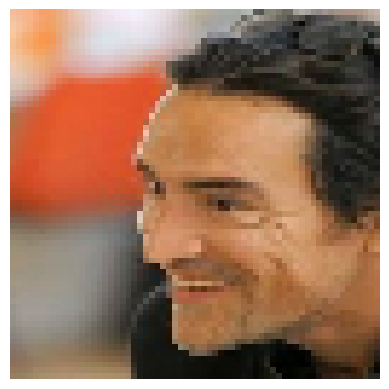

In [ ]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf

img_folder = '/content/celeba/img_align_celeba/img_align_celeba'
img_width, img_height = 178, 218  # Original dimensions
new_width, new_height = 64, 64  # New dimensions for our model

# Function to load and preprocess a single image
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [new_height, new_width])
    image /= 255.0  # Normalize to [0,1] range
    return image

# Load a sample image
sample_image_path = os.path.join(img_folder, '000041.jpg')
plt.imshow(load_and_preprocess_image(sample_image_path))
plt.axis('off')  # Hide the axis
plt.show()


In [ ]:
import pandas as pd
# Load attribute labels
attributes_df = pd.read_csv('/content/celeba/list_attr_celeba.csv')
attributes_df.set_index('image_id', inplace=True)

# Processing function to convert attribute labels from -1/1 to 0/1
def process_attributes(attr):
    return (attr + 1) // 2

# Apply the processing function to all attribute labels
processed_attributes_df = process_attributes(attributes_df)

# Load Evaluation Partitions
partition_df = pd.read_csv('/content/celeba/list_eval_partition.csv')

# Split the Dataset
train_df = partition_df[partition_df['partition'] == 0]
val_df = partition_df[partition_df['partition'] == 1]
test_df = partition_df[partition_df['partition'] == 2]

train_paths = [os.path.join(img_folder, fname) for fname in train_df['image_id']]
val_paths = [os.path.join(img_folder, fname) for fname in val_df['image_id']]
test_paths = [os.path.join(img_folder, fname) for fname in test_df['image_id']]

# Map the filenames to their corresponding attribute labels
train_labels = processed_attributes_df.loc[train_df['image_id']].values.astype('float32')
val_labels = processed_attributes_df.loc[val_df['image_id']].values.astype('float32')
test_labels = processed_attributes_df.loc[test_df['image_id']].values.astype('float32')


# Create datasets with labels
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels)).map(lambda x, y: (load_and_preprocess_image(x), y), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels)).map(lambda x, y: (load_and_preprocess_image(x), y), num_parallel_calls=tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels)).map(lambda x, y: (load_and_preprocess_image(x), y), num_parallel_calls=tf.data.AUTOTUNE)

BATCH_SIZE = 32
#  batching step
train_ds = train_ds.shuffle(buffer_size=len(train_paths)).batch(BATCH_SIZE).repeat().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).repeat().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Shape of the data in the train_ds
for images, labels in train_ds.take(1):
    print('Images batch shape:', images.shape)
    print('Labels batch shape:', labels.shape)

Images batch shape: (32, 64, 64, 3)
Labels batch shape: (32, 40)


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(new_width, new_height, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(processed_attributes_df.shape[1], activation='sigmoid')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.AUC(name='auc')])



# Display the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 64, 64, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 128)       512       
 chNormalization)                                                
                                                        

In [ ]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=7,
    steps_per_epoch=len(train_paths) // BATCH_SIZE,
    validation_steps=len(val_paths) // BATCH_SIZE
)

Epoch 1/7
5086/5086 [==============================] - 163s 20ms/step - loss: 0.3449 - auc: 0.8743 - val_loss: 0.3078 - val_auc: 0.9096
Epoch 2/7
5086/5086 [==============================] - 190s 37ms/step - loss: 0.2872 - auc: 0.9159 - val_loss: 0.2546 - val_auc: 0.9379
Epoch 3/7
5086/5086 [==============================] - 163s 32ms/step - loss: 0.2548 - auc: 0.9355 - val_loss: 0.2367 - val_auc: 0.9449
Epoch 4/7
5086/5086 [==============================] - 147s 29ms/step - loss: 0.2407 - auc: 0.9431 - val_loss: 0.2353 - val_auc: 0.9475
Epoch 5/7
5086/5086 [==============================] - 153s 30ms/step - loss: 0.2333 - auc: 0.9468 - val_loss: 0.2237 - val_auc: 0.9519
Epoch 6/7
5086/5086 [==============================] - 150s 29ms/step - loss: 0.2288 - auc: 0.9491 - val_loss: 0.2406 - val_auc: 0.9443
Epoch 7/7
5086/5086 [==============================] - 148s 29ms/step - loss: 0.2251 - auc: 0.9509 - val_loss: 0.2212 - val_auc: 0.9457


In [ ]:
# Evaluate the model on the test dataset
test_loss, test_auc, = model.evaluate(test_ds, steps=len(test_paths) // BATCH_SIZE)

# Print the test AUC
print("Test AUC:", test_auc)

623/623 [==============================] - 8s 12ms/step - loss: 0.2284 - auc: 0.9431
Test AUC: 0.9431762027740479


Using random search to find best configuration

In [ ]:
from google.colab import files
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import ParameterSampler
import numpy as np

# Define the parameter grid
param_grid = {
    'conv1_out_channels': [32, 64, 128],
    'conv2_out_channels': [64, 128, 256],
    'conv3_out_channels': [128, 256, 512],
    'conv4_out_channels': [256, 512, 1024],
}

# Number of configurations to sample
n_configs = 7

# Track the best configuration and its corresponding test AUC
best_auc = 0
best_config = None

# Sample configurations from the parameter grid
param_sampler = ParameterSampler(param_grid, n_configs, random_state=42)

# Iterate over sampled configurations
for i, params in enumerate(param_sampler):
    print(f"Experiment {i+1}/{n_configs}:")
    print(params)

    # Build the model using the sampled parameters
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(params['conv1_out_channels'], (3, 3), activation='relu', padding='same', input_shape=(new_width, new_height, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(params['conv2_out_channels'], (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(params['conv3_out_channels'], (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(params['conv4_out_channels'], (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(processed_attributes_df.shape[1], activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[tf.keras.metrics.AUC(name='auc')])

    # Train the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=5,
        steps_per_epoch=len(train_paths) // BATCH_SIZE,
        validation_steps=len(val_paths) // BATCH_SIZE
    )

    # Evaluate the model on the test dataset
    test_loss, test_auc = model.evaluate(test_ds, steps=len(test_paths) // BATCH_SIZE)

    # Print the test AUC
    print("Test AUC:", test_auc)
    print()

    # Update the best configuration if necessary
    if test_auc > best_auc:
        best_auc = test_auc
        best_config = params

print("Best Configuration:")
print(best_config)
print("Best Test AUC:", best_auc)

Experiment 1/7:
{'conv4_out_channels': 256, 'conv3_out_channels': 256, 'conv2_out_channels': 64, 'conv1_out_channels': 64}
Epoch 1/5
5086/5086 [==============================] - 136s 15ms/step - loss: 0.3195 - auc: 0.8945 - val_loss: 0.2722 - val_auc: 0.9291
Epoch 2/5
5086/5086 [==============================] - 145s 28ms/step - loss: 0.2649 - auc: 0.9299 - val_loss: 0.2688 - val_auc: 0.9276
Epoch 3/5
5086/5086 [==============================] - 140s 28ms/step - loss: 0.2437 - auc: 0.9415 - val_loss: 0.2318 - val_auc: 0.9469
Epoch 4/5
5086/5086 [==============================] - 126s 25ms/step - loss: 0.2339 - auc: 0.9465 - val_loss: 0.2201 - val_auc: 0.9528
Epoch 5/5
623/623 [==============================] - 8s 12ms/step - loss: 0.2251 - auc: 0.9520
Test AUC: 0.9519663453102112

Experiment 2/7:
{'conv4_out_channels': 256, 'conv3_out_channels': 128, 'conv2_out_channels': 64, 'conv1_out_channels': 32}
Epoch 1/5
5086/5086 [==============================] - 127s 13ms/step - loss: 0.3193 

Hyperparameter tuning on the best configuration found

In [ ]:
import pandas as pd
# Load attribute labels
attributes_df = pd.read_csv('/content/celeba/list_attr_celeba.csv')
attributes_df.set_index('image_id', inplace=True)

# Processing function to convert attribute labels from -1/1 to 0/1
def process_attributes(attr):
    return (attr + 1) // 2

# Apply the processing function to all attribute labels
processed_attributes_df = process_attributes(attributes_df)

# Load Evaluation Partitions
partition_df = pd.read_csv('/content/celeba/list_eval_partition.csv')

# Split the Dataset
train_df = partition_df[partition_df['partition'] == 0]
val_df = partition_df[partition_df['partition'] == 1]
test_df = partition_df[partition_df['partition'] == 2]

train_paths = [os.path.join(img_folder, fname) for fname in train_df['image_id']]
val_paths = [os.path.join(img_folder, fname) for fname in val_df['image_id']]
test_paths = [os.path.join(img_folder, fname) for fname in test_df['image_id']]

# Map the filenames to their corresponding attribute labels
train_labels = processed_attributes_df.loc[train_df['image_id']].values.astype('float32')
val_labels = processed_attributes_df.loc[val_df['image_id']].values.astype('float32')
test_labels = processed_attributes_df.loc[test_df['image_id']].values.astype('float32')


# Create datasets with labels
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels)).map(lambda x, y: (load_and_preprocess_image(x), y), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels)).map(lambda x, y: (load_and_preprocess_image(x), y), num_parallel_calls=tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels)).map(lambda x, y: (load_and_preprocess_image(x), y), num_parallel_calls=tf.data.AUTOTUNE)


In [ ]:
import tensorflow as tf


batch_sizes = [16, 32, 64]
learning_rates = [0.001, 0.0001]

best_auc = 0.0
best_batch_size = None
best_learning_rate = None

for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        print("Training with batch size:", batch_size, "and learning rate:", learning_rate)
        #  batching step
        train_ds_batch = train_ds.shuffle(buffer_size=len(train_paths)).batch(batch_size).repeat().prefetch(tf.data.AUTOTUNE)
        val_ds_batch = val_ds.batch(batch_size).repeat().prefetch(tf.data.AUTOTUNE)
        test_ds_batch = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

        # Create and compile the model
        model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(new_width, new_height, 3)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),

            tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),

            tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),

            tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),

            tf.keras.layers.Flatten(),

            tf.keras.layers.Dense(1024, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dropout(0.5),

            tf.keras.layers.Dense(processed_attributes_df.shape[1], activation='sigmoid')
        ])

        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

        model.compile(optimizer=optimizer,
                      loss=tf.keras.losses.BinaryCrossentropy(),
                      metrics=[tf.keras.metrics.AUC(name='auc')])

        # Train the model
        history = model.fit(
            train_ds_batch,
            validation_data=val_ds_batch,
            epochs=5,
            steps_per_epoch=len(train_paths) // batch_size,
            validation_steps=len(val_paths) // batch_size
        )

        # Evaluate the model on the test dataset
        test_loss, test_auc = model.evaluate(test_ds_batch, steps=len(test_paths) // batch_size)


        print("Test AUC with batch size:", batch_size, "and learning rate:", learning_rate, ":", test_auc)

        # Check if this combination has the highest AUC
        if test_auc > best_auc:
            best_auc = test_auc
            best_batch_size = batch_size
            best_learning_rate = learning_rate

print("Best AUC:", best_auc)
print("Best batch size:", best_batch_size)
print("Best learning rate:", best_learning_rate)


Training with batch size: 16 and learning rate: 0.001
Epoch 1/5
10173/10173 [==============================] - 256s 19ms/step - loss: 0.3403 - auc: 0.8782 - val_loss: 0.3487 - val_auc: 0.8697
Epoch 2/5
10173/10173 [==============================] - 249s 24ms/step - loss: 0.2683 - auc: 0.9279 - val_loss: 0.2880 - val_auc: 0.9155
Epoch 3/5
10173/10173 [==============================] - 248s 24ms/step - loss: 0.2500 - auc: 0.9383 - val_loss: 0.2392 - val_auc: 0.9438
Epoch 4/5
10173/10173 [==============================] - 247s 24ms/step - loss: 0.2432 - auc: 0.9420 - val_loss: 0.2313 - val_auc: 0.9484
Epoch 5/5
1247/1247 [==============================] - 9s 7ms/step - loss: 0.2361 - auc: 0.9476
Test AUC with batch size: 16 and learning rate: 0.001 : 0.9476488828659058
Training with batch size: 16 and learning rate: 0.0001
Epoch 1/5
10173/10173 [==============================] - 256s 19ms/step - loss: 0.3312 - auc: 0.8855 - val_loss: 0.2730 - val_auc: 0.9349
Epoch 2/5
10173/10173 [=======

Best model

In [ ]:
import pandas as pd
# Load attribute labels
attributes_df = pd.read_csv('/content/celeba/list_attr_celeba.csv')
attributes_df.set_index('image_id', inplace=True)

# Processing function to convert attribute labels from -1/1 to 0/1
def process_attributes(attr):
    return (attr + 1) // 2

# Apply the processing function to all attribute labels
processed_attributes_df = process_attributes(attributes_df)

# Load Evaluation Partitions
partition_df = pd.read_csv('/content/celeba/list_eval_partition.csv')

# Split the Dataset
train_df = partition_df[partition_df['partition'] == 0]
val_df = partition_df[partition_df['partition'] == 1]
test_df = partition_df[partition_df['partition'] == 2]

train_paths = [os.path.join(img_folder, fname) for fname in train_df['image_id']]
val_paths = [os.path.join(img_folder, fname) for fname in val_df['image_id']]
test_paths = [os.path.join(img_folder, fname) for fname in test_df['image_id']]

# Map the filenames to their corresponding attribute labels
train_labels = processed_attributes_df.loc[train_df['image_id']].values.astype('float32')
val_labels = processed_attributes_df.loc[val_df['image_id']].values.astype('float32')
test_labels = processed_attributes_df.loc[test_df['image_id']].values.astype('float32')


# Create datasets with labels
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels)).map(lambda x, y: (load_and_preprocess_image(x), y), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels)).map(lambda x, y: (load_and_preprocess_image(x), y), num_parallel_calls=tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels)).map(lambda x, y: (load_and_preprocess_image(x), y), num_parallel_calls=tf.data.AUTOTUNE)



In [ ]:
BATCH_SIZE = 64
#  batching step
train_ds = train_ds.shuffle(buffer_size=len(train_paths)).batch(BATCH_SIZE).repeat().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).repeat().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Shape of the data in the train_ds
for images, labels in train_ds.take(1):
    print('Images batch shape:', images.shape)
    print('Labels batch shape:', labels.shape)


model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(new_width, new_height, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(processed_attributes_df.shape[1], activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.AUC(name='auc')])



# Display the model's architecture
model.summary()

Images batch shape: (64, 64, 64, 3)
Labels batch shape: (64, 40)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 64, 64, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 256)       147712    
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 256)       1024      
 chNormalization)                                        

In [ ]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    steps_per_epoch=len(train_paths) // BATCH_SIZE,
    validation_steps=len(val_paths) // BATCH_SIZE
)

Epoch 1/15
2543/2543 [==============================] - 189s 48ms/step - loss: 0.3453 - auc: 0.8750 - val_loss: 0.2654 - val_auc: 0.9319
Epoch 2/15
2543/2543 [==============================] - 173s 68ms/step - loss: 0.2814 - auc: 0.9198 - val_loss: 0.2430 - val_auc: 0.9450
Epoch 3/15
2543/2543 [==============================] - 184s 72ms/step - loss: 0.2620 - auc: 0.9314 - val_loss: 0.2348 - val_auc: 0.9492
Epoch 4/15
2543/2543 [==============================] - 158s 62ms/step - loss: 0.2503 - auc: 0.9379 - val_loss: 0.2287 - val_auc: 0.9520
Epoch 5/15
2543/2543 [==============================] - 167s 66ms/step - loss: 0.2419 - auc: 0.9423 - val_loss: 0.2248 - val_auc: 0.9537
Epoch 6/15
2543/2543 [==============================] - 167s 65ms/step - loss: 0.2348 - auc: 0.9459 - val_loss: 0.2213 - val_auc: 0.9549
Epoch 7/15
2543/2543 [==============================] - 166s 65ms/step - loss: 0.2285 - auc: 0.9490 - val_loss: 0.2180 - val_auc: 0.9546
Epoch 8/15
2543/2543 [===================

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_auc, = model.evaluate(test_ds, steps=len(test_paths) // BATCH_SIZE)

print("Test AUC:", test_auc)

311/311 [==============================] - 9s 27ms/step - loss: 0.1936 - auc: 0.9583
Test AUC: 0.9583140669822693


In [ ]:
def predict_attributes(model, image_path):
    # Load and preprocess the image
    image = load_and_preprocess_image(image_path)

    # Add an extra dimension for batch size (model expects batches)
    image = tf.expand_dims(image, 0)

    # Make a prediction
    predictions = model.predict(image)

    # The model outputs probabilities;threshold them to get binary predictions
    threshold = 0.5
    binary_predictions = tf.cast(predictions > threshold, tf.int32)

    # Get attribute names
    attribute_names = processed_attributes_df.columns.tolist()

    # Map binary predictions back to attribute names
    predicted_attributes = [attribute_names[i] for i, val in enumerate(binary_predictions[0]) if val == 1]

    # Display the image with predicted attributes
    plt.imshow(image[0])
    plt.title('Predicted Attributes: {}'.format(predicted_attributes))
    plt.axis('off')
    plt.show()

In [ ]:
from google.colab import files

uploaded = files.upload()

# Iterate through the uploaded files
for filename in uploaded.keys():
    print('Uploaded file:', filename)

Saving jhonny.jpeg to jhonny.jpeg
Uploaded file: jhonny.jpeg


1/1 [==============================] - 0s 27ms/step


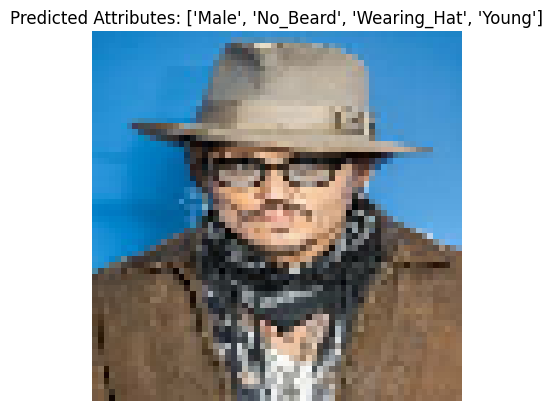

In [ ]:
custom_image_path = 'jhonny.jpeg'
predict_attributes(model, custom_image_path)

In [ ]:
from google.colab import files

uploaded = files.upload()

# Iterate through the uploaded files
for filename in uploaded.keys():
    print('Uploaded file:', filename)

Saving test.jpeg to test.jpeg
Uploaded file: test.jpeg


1/1 [==============================] - 1s 837ms/step


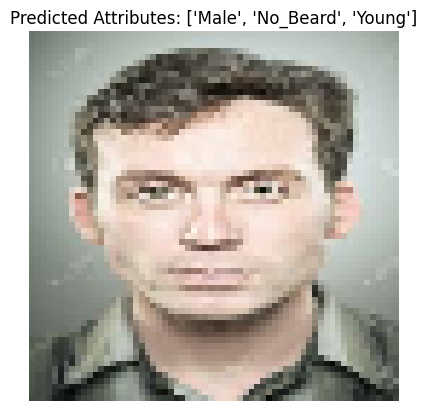

In [ ]:
custom_image_path = 'test.jpeg'
predict_attributes(model, custom_image_path)